# Import needed modules

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully 

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import Model, regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')
print(tf.__version__)

modules loaded
2.9.1


In [3]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/wo-singkong/i-WO Singkong - Split-98.65.h5')
print("Model Loaded")

Model Loaded


In [4]:
last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
last_conv_layer.name

'top_conv'

In [5]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array

# Grad-Cam

In [6]:
def VizGradCAM(model, image, interpolant=0.5, plot_results=True):

    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function    should work with all Keras Application listed here:
    https://keras.io/api/applications/
    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array
    Returns:
    Heatmap Array?
    """
    #sanity check
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    #STEP 1: Preprocesss image and make prediction using our model
    #input image
    original_img = np.asarray(image, dtype = np.float32)
    #expamd dimension and get batch size
    img = np.expand_dims(original_img, axis=0)
    #predict
    prediction = model.predict(img)
    #prediction index
    prediction_idx = np.argmax(prediction)

    #STEP 2: Create new model
    #specify last convolutional layer
    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    #compute gradient of top predicted class
    with tf.GradientTape() as tape:
        #create a model with original model inputs and the last conv_layer as the output
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        #pass the image through the base model and get the feature map
        conv2d_out, prediction = gradient_model(img)
        #prediction loss
        loss = prediction[:, prediction_idx]

    #gradient() computes the gradient using operations recorded in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    #obtain the output from shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    #obtain depthwise mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))


    #create a 7x7 map for aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)
    #multiply weight for every layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]
    #resize to image size
    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    #ensure no negative number
    activation_map = np.maximum(activation_map, 0)
    #convert class activation map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    #rescale and convert the type to int
    activation_map = np.uint8(255 * activation_map)


    #convert to heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    #superimpose heatmap onto image
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    #enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 [==============================] - 10s 10s/step


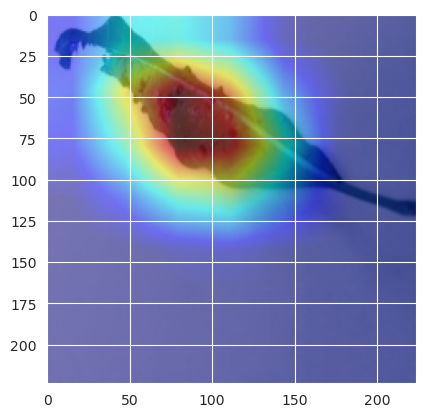

In [7]:
#load image
test_img = cv2.imread("/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test/Mangga_Gall_Midge/IMG_20211106_161105 (Custom).jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAM(model, img_to_array(resized_test_img), plot_results=True)

# With Bounding Box

In [8]:
def VizGradCAMBB(model, image, interpolant=0.5, plot_results=True, threshold=0.5):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cvt_heatmap = img_to_array(cvt_heatmap)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        overlaid_img = np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.imshow(overlaid_img)
    else:
        return cvt_heatmap

1/1 [==============================] - 0s 52ms/step


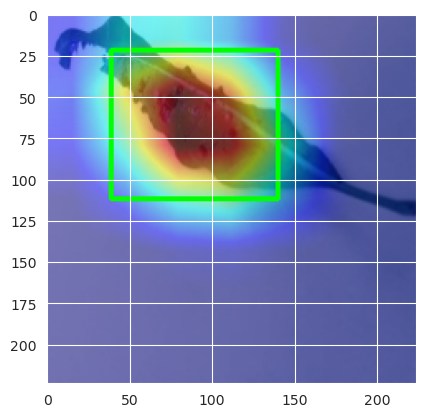

In [9]:
#load image
test_img = cv2.imread("/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test/Mangga_Gall_Midge/IMG_20211106_161105 (Custom).jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAMBB(model, img_to_array(resized_test_img), plot_results=True)

# Final

In [10]:
def VizGradCAMBBfix(model, image, interpolant=0.5, plot_results=True, threshold=0.8):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        overlaid_img = np.uint8(original_img * interpolant)

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        plt.imshow(overlaid_img)
    else:
        return activation_map  # Return activation map without heatmap

1/1 [==============================] - 0s 53ms/step


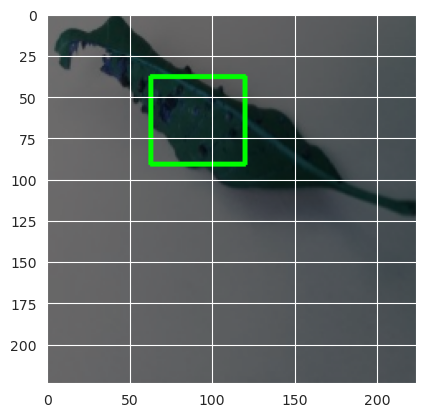

In [12]:
#load image
test_img = cv2.imread("/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test/Mangga_Gall_Midge/IMG_20211106_161105 (Custom).jpg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAMBBfix(model, img_to_array(resized_test_img), plot_results=True)

# Test Generator

In [17]:
test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory('/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test',
                                        target_size=(224, 224),
                                        class_mode='categorical',
                                        shuffle=True)

Found 1932 images belonging to 26 classes.


In [14]:
[test_data.class_indices.keys()]

[dict_keys(['Jagung_Blight', 'Jagung_Common_Rust', 'Jagung_Gray_Leaf_Spot', 'Jagung_Healthy', 'Kentang__Early_blight', 'Kentang__Healthy', 'Kentang__Late_blight', 'Mangga_Anthracnose', 'Mangga_Bacterial_Canker', 'Mangga_Gall_Midge', 'Mangga_Healthy', 'Mangga_Powdery_Mildew', 'Mangga_Sooty_Mould', 'Padi_Bacterialblight', 'Padi_Blast', 'Padi_Brownspot', 'Padi_Healthy', 'Pisang_Cordana', 'Pisang_Healthy', 'Pisang_Pestalotiopsis', 'Pisang_Sigatoka', 'Tebu_Healthy', 'Tebu_Mosaic', 'Tebu_RedRot', 'Tebu_Rust', 'Tebu_Yellow'])]

In [15]:
class_names = ['Jagung_Blight', 'Jagung_Common_Rust', 'Jagung_Gray_Leaf_Spot', 'Jagung_Healthy', 'Kentang__Early_blight', 'Kentang__Healthy', 'Kentang__Late_blight', 'Mangga_Anthracnose', 'Mangga_Bacterial_Canker', 'Mangga_Gall_Midge', 'Mangga_Healthy', 'Mangga_Powdery_Mildew', 'Mangga_Sooty_Mould', 'Padi_Bacterialblight', 'Padi_Blast', 'Padi_Brownspot', 'Padi_Healthy', 'Pisang_Cordana', 'Pisang_Healthy', 'Pisang_Pestalotiopsis', 'Pisang_Sigatoka', 'Tebu_Healthy', 'Tebu_Mosaic', 'Tebu_RedRot', 'Tebu_Rust', 'Tebu_Yellow']

1/1 [==============================] - 0s 50ms/step


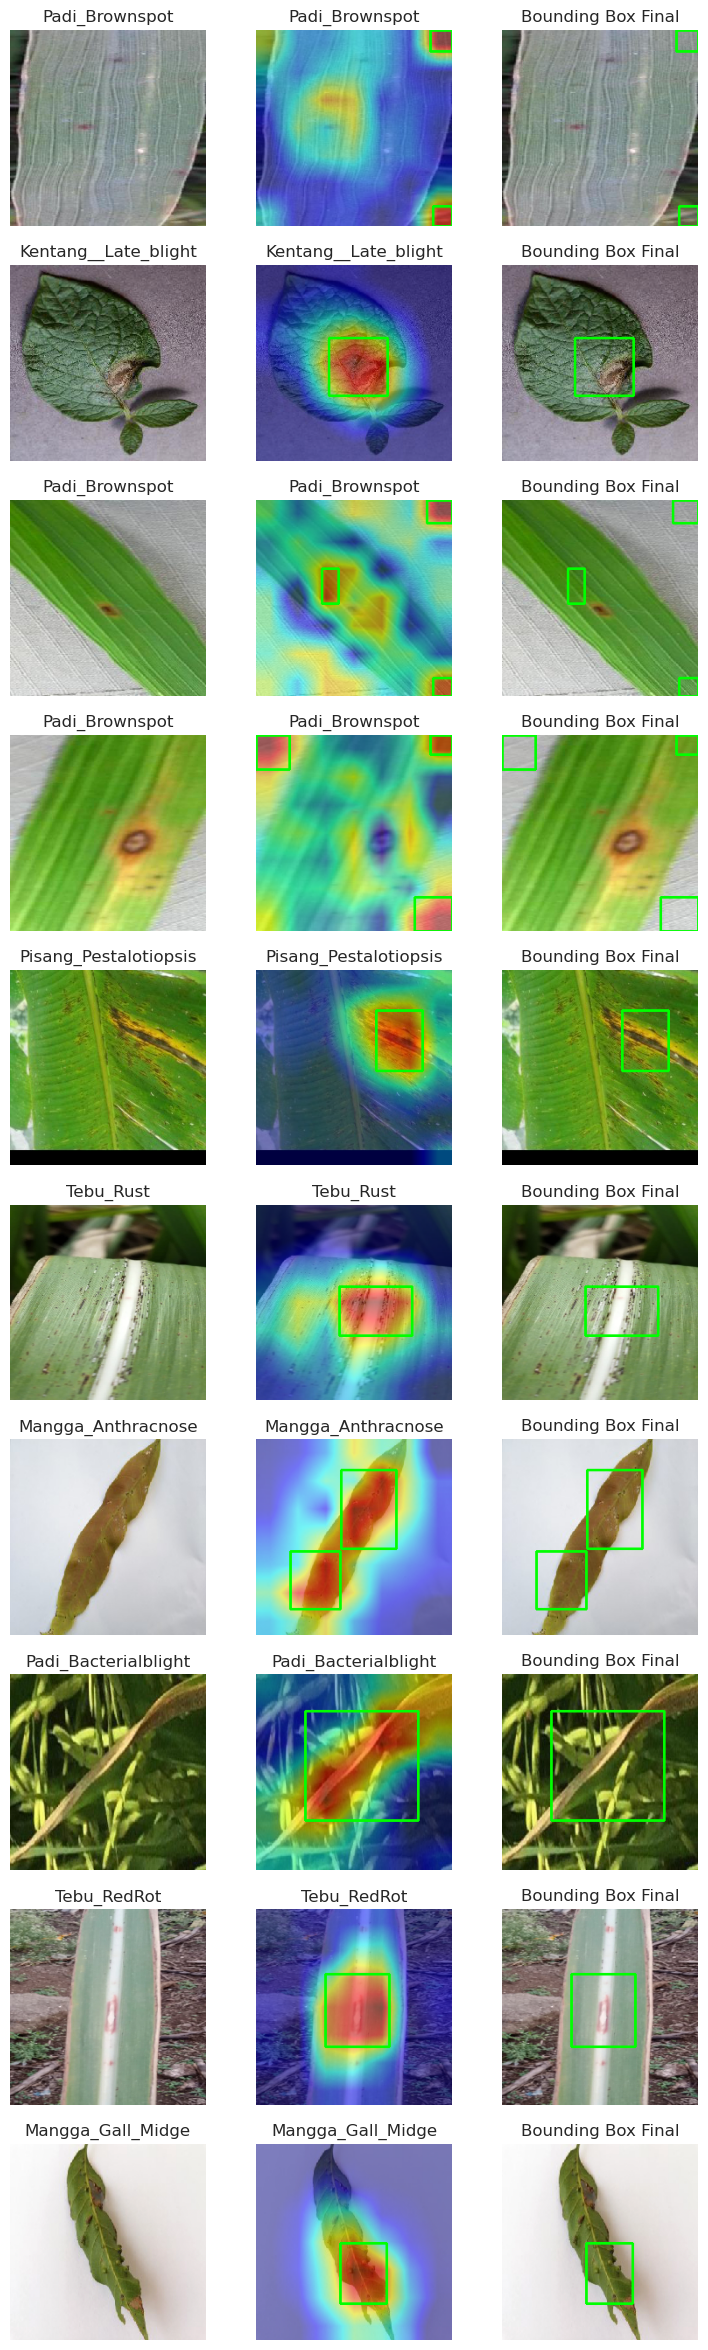

In [18]:
def VizGradCAMBB_batch(model, test_data, num_images, threshold, interpolant=0.5):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Fetch a batch of test data
    batch_images, batch_labels = next(test_data)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    fig, axes = plt.subplots(num_images, 3, figsize=(9, 3 * num_images))

    for i in range(num_images):
        original_img = np.asarray(batch_images[i], dtype=np.float32)
        img = np.expand_dims(original_img, axis=0)
        prediction = model.predict(img)
        prediction_idx = np.argmax(prediction)

        last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
        target_layer = model.get_layer(last_conv_layer.name)

        with tf.GradientTape() as tape:
            gradient_model = Model([model.inputs], [target_layer.output, model.output])
            conv2d_out, prediction = gradient_model(img)
            loss = prediction[:, prediction_idx]

        gradients = tape.gradient(loss, conv2d_out)
        output = conv2d_out[0]
        weights = tf.reduce_mean(gradients[0], axis=(0, 1))
        activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

        for idx, weight in enumerate(weights):
            activation_map += weight * output[:, :, idx]

        activation_map = cv2.resize(activation_map.numpy(),
                                    (original_img.shape[1],
                                     original_img.shape[0]))
        activation_map = np.maximum(activation_map, 0)
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
        activation_map = np.uint8(255 * activation_map)

        heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
        original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
        cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        cvt_heatmap = img_to_array(cvt_heatmap)

        # Plot original image in the left column with label
        true_label = class_names[np.argmax(batch_labels[i])]
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(true_label)
        axes[i, 0].axis('off')

        # Plot Grad-CAM result in the middle column
        overlaid_img = np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axes[i, 1].imshow(overlaid_img)
        axes[i, 1].set_title(class_names[prediction_idx])
        axes[i, 1].axis('off')

        # Plot the final image with bounding boxes only in the right column
        bounding_box_img = np.copy(original_img)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(bounding_box_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        axes[i, 2].imshow(bounding_box_img)
        axes[i, 2].set_title("Bounding Box Final")
        axes[i, 2].axis('off')

    plt.show()

# Example usage
VizGradCAMBB_batch(model, test_data, num_images=10, threshold=0.75, interpolant=0.5)

# Label and Prediksi

In [20]:
test_ds = keras.utils.image_dataset_from_directory(
    '/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test',
    image_size=(224,224),
    batch_size=32,
    shuffle=True
)

Found 1932 files belonging to 26 classes.


In [21]:
def img_to_pred(image):
    image = image.numpy()
    image = tf.expand_dims(image,0)
    return image

1/1 [==============================] - 0s 50ms/step


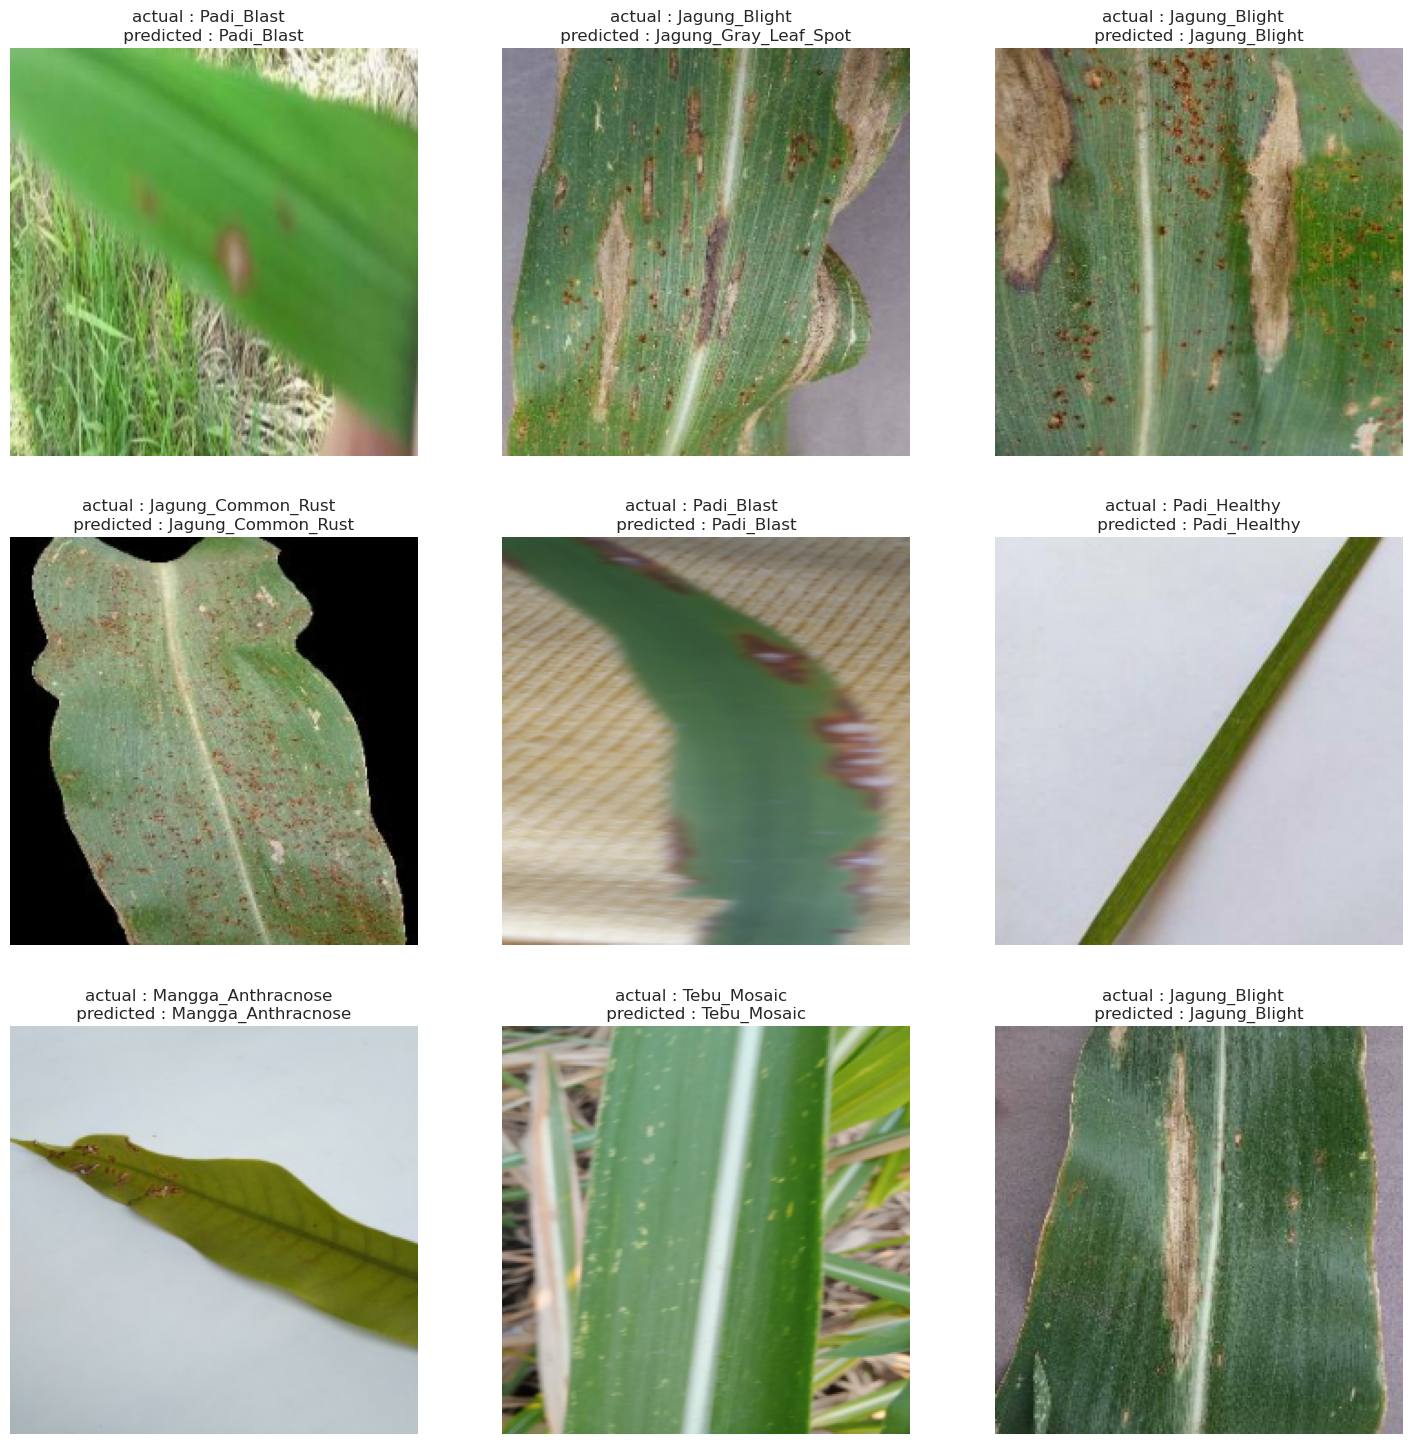

In [22]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1) : # take the first patch
    for i in range(1,10):
        plt.subplot(3,3,i)
        plt.imshow(images[i].numpy().astype('uint32'))
        plt.axis('off')
        actual = class_names[labels[i]]
        predict =class_names[np.argmax(model.predict(img_to_pred(images[i])))]
        plt.title(f"actual : {actual}  \n predicted : {predict} ")

# IoU Calculation

In [27]:
def VizGradCAMBBfixIoU(model, image, interpolant=0.5, plot_results=True, threshold=0.8):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)

    last_conv_layer = next(x for x in model.layers[::-1] if isinstance(x, tf.keras.layers.Conv2D))
    target_layer = model.get_layer(last_conv_layer.name)

    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)
    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(),
                                (original_img.shape[1],
                                 original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)

    # Enlarge plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results:
        overlaid_img = np.uint8(original_img * interpolant)

        # Apply thresholding to the heatmap
        thresholded_heatmap = cv2.threshold(activation_map, 255 * threshold, 255, cv2.THRESH_BINARY)[1]

        # Find contours in the thresholded heatmap
        contours, _ = cv2.findContours(thresholded_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Draw bounding boxes on the original image
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(overlaid_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            global bbcoor
            bbcoor = [x,y,w,h]
            print(bbcoor)

        plt.imshow(overlaid_img)
    else:
        return activation_map  # Return activation map without heatmap

1/1 [==============================] - 0s 52ms/step
[126, 156, 40, 39]


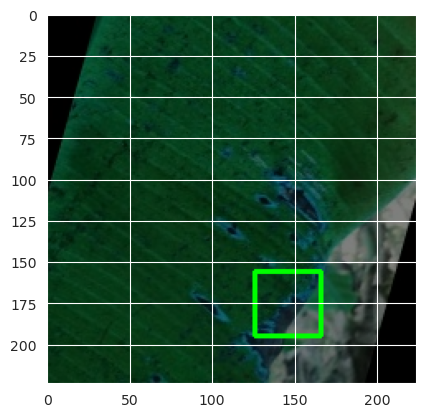

In [28]:
#load image
test_img = cv2.imread("/kaggle/input/wo-nangka-selada-singkong-daun-sehat-split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/New Dataset - PlantLeafDataset - (WO Nangka Selada Singkong - Daun Sehat) - Split/test/Pisang_Pestalotiopsis/15.jpeg")

# Resize the test_img to (240, 240)
resized_test_img = cv2.resize(test_img, (224, 224))

#apply function
VizGradCAMBBfixIoU(model, img_to_array(resized_test_img), plot_results=True)

In [37]:
def get_IoU(boxA, boxB):
    # boxA -> Ground Truth
    # boxB -> Prediction
    # determine the (x, y)-coordinates of the intersection rectangle

    global xA, yA, xB, yB

    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])

    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value

    return iou

In [38]:
bbcoor

[126, 156, 40, 39]

In [40]:
# Ground Truth, Predicted
get_IoU([126, 150, 46, 39], bbcoor)

0.0

In [34]:
print(xA, yA, xB, yB)

126 156 40 39
